In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
with open("results/results.jsonl") as fp:
    lines = fp.readlines()
experiments = [json.loads(line) for line in lines]
results = pd.DataFrame.from_records(experiments)
results.head()

,ntasks,cumulative_time,times,launch_time,end_time,method,module,nodes,setup
0,16,46.637321,"[0.22058981301961467, 3.0710751229780726, 3.08...",0.027557,5.611601,lazy,numpy,16,2.753292
1,32,97.915800,"[0.5076789679587819, 3.0653867590008304, 3.065...",0.033360,5.623365,lazy,numpy,16,0.704478
2,64,198.229951,"[0.2265696310205385, 3.0522600680124015, 3.052...",0.041374,5.658889,lazy,numpy,16,0.668836
3,128,420.705663,"[0.2298712719930336, 0.05318021395942196, 3.05...",0.062729,6.586073,lazy,numpy,16,0.645196
4,256,576.369469,"[0.055582841974683106, 0.054839075019117445, 0...",0.113638,9.431395,lazy,numpy,16,0.533750


In [10]:
results["avg_time"] = results["times"].apply(lambda x: np.mean(x))
results["tasks_per_node"] = results["ntasks"] / results["nodes"]
results.head()

,ntasks,cumulative_time,times,launch_time,end_time,method,module,nodes,setup,avg_time,tasks_per_node
0,16,46.637321,"[0.22058981301961467, 3.0710751229780726, 3.08...",0.027557,5.611601,lazy,numpy,16,2.753292,2.914833,1.0
1,32,97.915800,"[0.5076789679587819, 3.0653867590008304, 3.065...",0.033360,5.623365,lazy,numpy,16,0.704478,3.059869,2.0
2,64,198.229951,"[0.2265696310205385, 3.0522600680124015, 3.052...",0.041374,5.658889,lazy,numpy,16,0.668836,3.097343,4.0
3,128,420.705663,"[0.2298712719930336, 0.05318021395942196, 3.05...",0.062729,6.586073,lazy,numpy,16,0.645196,3.286763,8.0
4,256,576.369469,"[0.055582841974683106, 0.054839075019117445, 0...",0.113638,9.431395,lazy,numpy,16,0.533750,2.251443,16.0


In [4]:
def plot_time_vs_tasks(nodes=1, modules=["numpy", "tensorflow"], y="avg_time"):
    for i, module in enumerate(modules):
        plt.subplot(1, len(modules), i+1)
        df = results[results["nodes"] == nodes]
        df = df[df["module"] == module]
        sns.barplot(data=df, x="ntasks", y=y, hue="method")
        plt.title(f"Module: {module}")
    plt.gcf().suptitle(f"{y} for nodes: {nodes}")

In [24]:
def plot_time_vs_nodes(tasks_per_node=1, modules=["numpy", "tensorflow"], y="avg_time"):
    for i, module in enumerate(modules):
        plt.subplot(1, len(modules), i+1)
        df = results[results["tasks_per_node"] == tasks_per_node]
        df = df[df["module"] == module]
        sns.barplot(data=df, x="nodes", y=y, hue="method")
        plt.title(f"Module: {module}")
    plt.gcf().suptitle(f"{y} for {tasks_per_node} tasks per node")

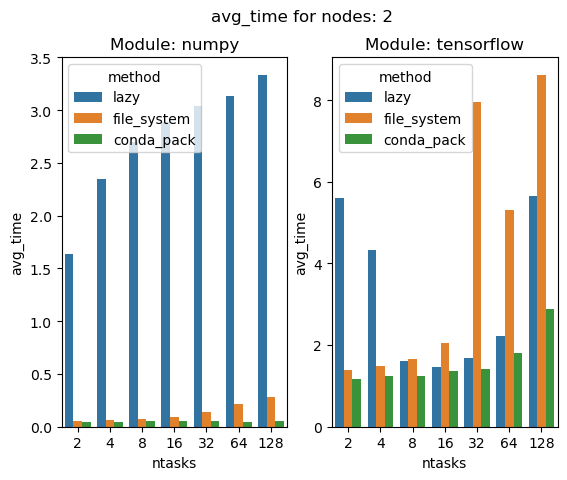

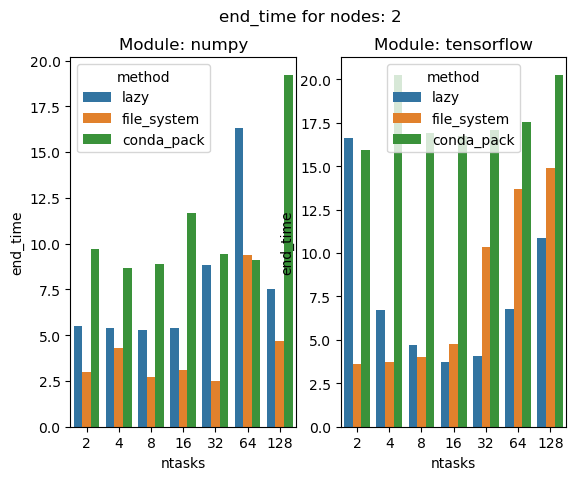

In [5]:
plot_time_vs_tasks(2)
plt.show()
plot_time_vs_tasks(2, y="end_time")
plt.show()

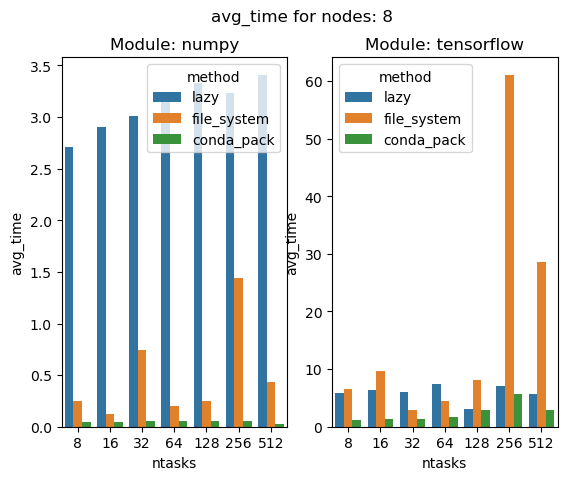

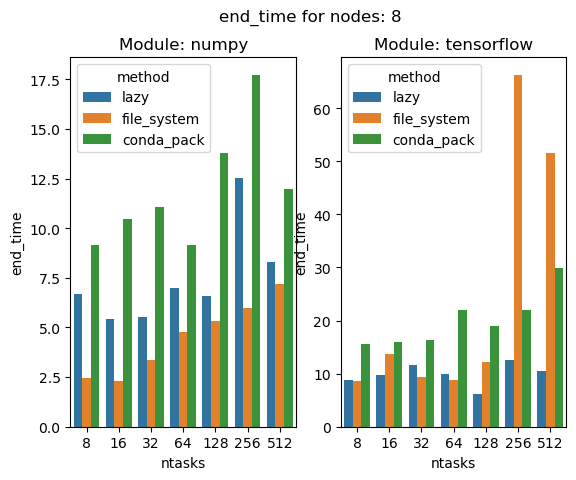

In [6]:
plot_time_vs_tasks(8)
plt.show()
plot_time_vs_tasks(8, y="end_time")
plt.show()

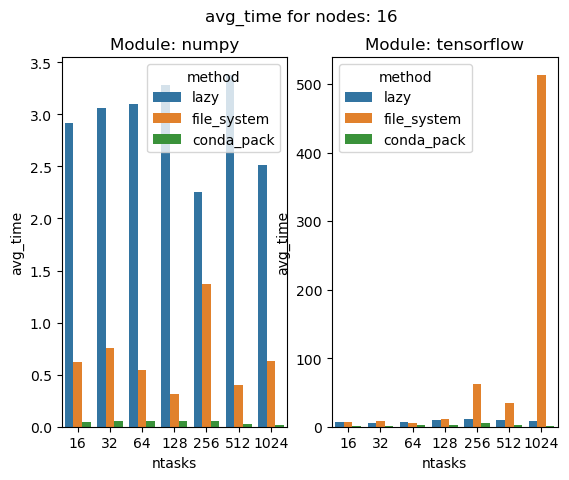

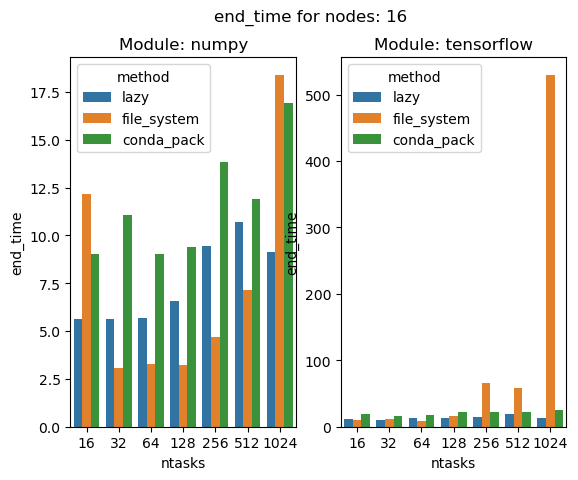

In [7]:
plot_time_vs_tasks(16)
plt.show()
plot_time_vs_tasks(16, y="end_time")
plt.show()

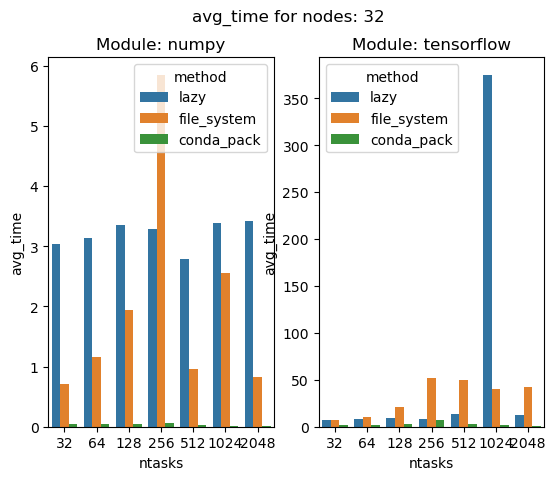

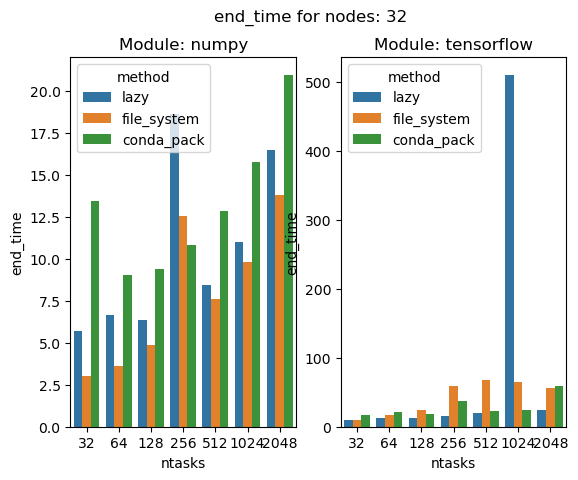

In [18]:
plot_time_vs_tasks(32)
plt.show()
plot_time_vs_tasks(32, y="end_time")
plt.show()

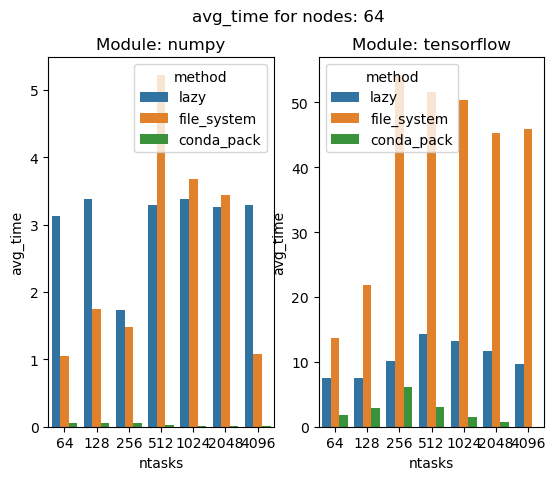

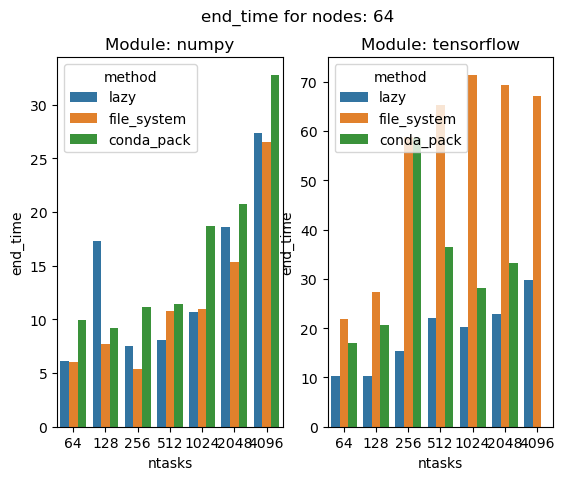

In [8]:
plot_time_vs_tasks(64)
plt.show()
plot_time_vs_tasks(64, y="end_time")
plt.show()

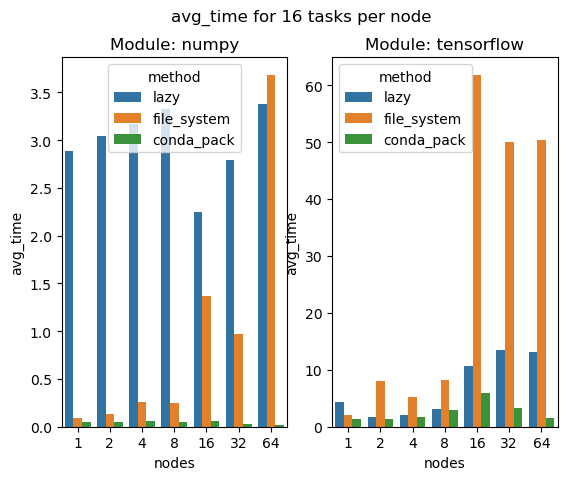

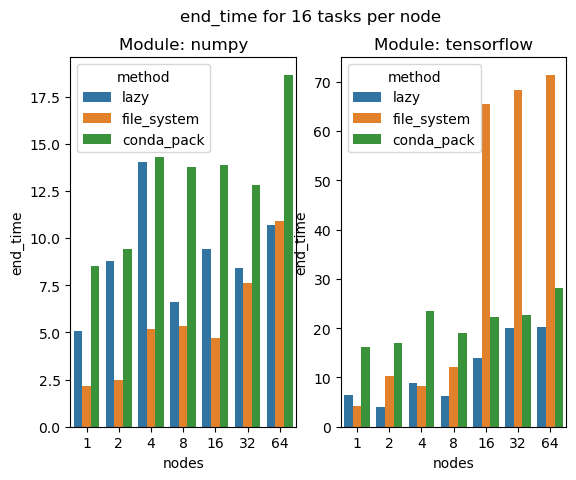

In [25]:
plot_time_vs_nodes(16)
plt.show()
plot_time_vs_nodes(16, y="end_time")
plt.show()

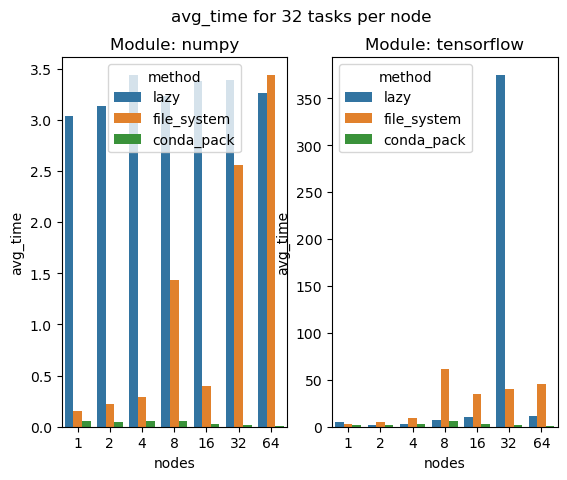

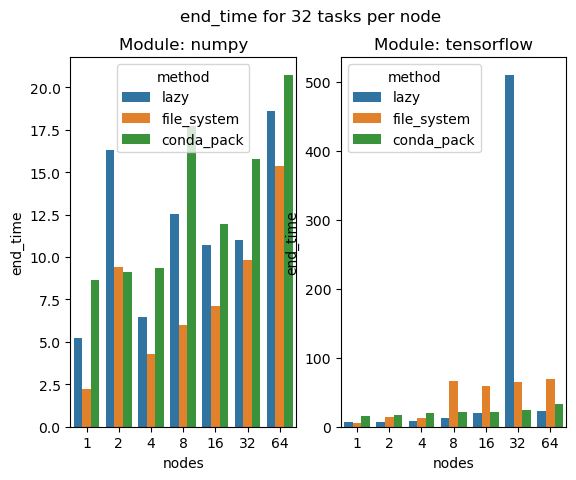

In [26]:
plot_time_vs_nodes(32)
plt.show()
plot_time_vs_nodes(32, y="end_time")
plt.show()

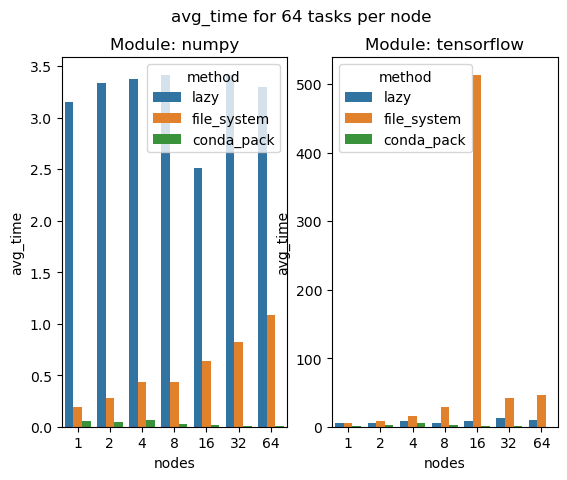

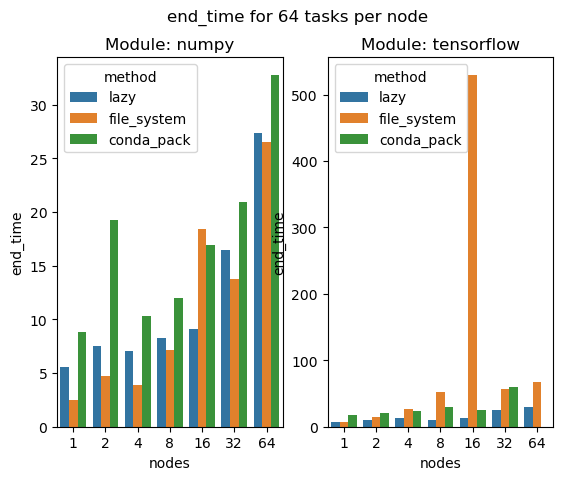

In [27]:
plot_time_vs_nodes(64)
plt.show()
plot_time_vs_nodes(64, y="end_time")
plt.show()

## Quick Thoughts
 - The average import time for numpy using the lazy import method seems to be significantly slower. However, the most direct comparison (especially to conda pack) is the end time not the average time, since conda pack delegates the work of unpacking to the worker initialization script
 - The comparison also seems to improve as the number of nodes increase. Could this be because conda pack is trying to load a large tar file from the shared file system? Using the file store (which is what these are currently using) we are doing the same, but the tar file is much smaller
 - Looking at tensorflow, it seems like we may have something. Our method is consistently better than the file system, and also seems to scale better than conda-pack (looking at higher node counts and task counts)
 - The lazy imports still need to be refined. The way it is currently set up, the linker path still must include the shared file system. This means that we can't (yet) use this method on systems where there is no shared file system. This could (?) be a reason that we are doing poorly in the numpy case, but I haven't verified this. As far as I can tell, the only way to find out which shared libraries are used is by refering to pip/conda (this is how poncho, the system described in the light-weight function monitors paper solves this problem).
 - For other python dependencies, right now we aren't moving them, but it's possible that we could add this
 - For context, from the light weight function monitors paper, numpy is 104MB and tensorflow is 259MB